# Journal Profiling Part 5: Competing Journals Analysis

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to create a competitive journals analysis report, starting from a specific journal and by using its authors information. 

This tutorial is the fifth of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.

In this notebook we are going to 

* Load the researchers impact metrics data previously extracted (see parts 1-2-3)
* Get the full publications history for these researchers 
* Use this new publications dataset to determine which are the most frequent journals the researchers have also published in
* Build some visualizations in order to have a quick overview of the results 

## Prerequisites: Installing the Dimensions Library and Logging in

In [1]:
# @markdown # Get the API library and login
# @markdown Click the 'play' button on the left (or shift+enter) after entering your API credentials

username = "" #@param {type: "string"}
password = "" #@param {type: "string"}
endpoint = "https://app.dimensions.ai" #@param {type: "string"}


!pip install dimcli plotly tqdm -U --quiet
import dimcli
from dimcli.shortcuts import *
dimcli.login(username, password, endpoint)
dsl = dimcli.Dsl()

#
# load common libraries
import pandas as pd
from pandas.io.json import json_normalize
from tqdm.notebook import tqdm as progress
import sys
import os
import json

#
# charts libs
# import plotly_express as px
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)
    
def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

Dimcli - Dimensions API Client (v0.6.9)
Connected to endpoint: https://app.dimensions.ai - DSL version: 1.24
Method: dsl.ini file


## Competing Journals

From our researchers master list, we now want to extract the following:

* full list of publications for a N year period
* full list of journals with counts of how many publications per journal 

This new dataset will let us draw up some conclusions re. which are the competing journals of the one we selected at the beginning.



### First let's reload the data obtained in previous steps

**NOTE** If you are using Google Colab or don't have the data available, just do the following: 
* open up the 'Files' panel in Google Colab and create a new folder `journal-profile-data`
* grab this [file](https://github.com/digital-science/dimensions-api-lab/tree/master/cookbooks/2-publications/journal-profile-data.zip), unzip it, open the enclosed folder and upload the file called `2_researchers_impact_metrics.csv` to Google Colab ('Upload' menu or also by dragging then inside the panel window)
* move the file inside the `journal-profile-data` folder you just created 

In [2]:
#
researchers = pd.read_csv(FOLDER_NAME+"/2_researchers_impact_metrics.csv")
#
print("Total researchers:", len(researchers))
researchers.head(5)

Total researchers: 18524


,researcher_id,pubs,full_name,citations_mean,altmetric_mean,last_pub_year,url
0,ur.0723426172.10,62,Kari Stefansson,107.516129,229.129032,2020,https://app.dimensions.ai/discover/publication...
1,ur.01277776417.51,45,Unnur Thorsteinsdottir,81.000000,159.555556,2019,https://app.dimensions.ai/discover/publication...
2,ur.01247426430.47,33,Gudmar Thorleifsson,80.818182,170.424242,2019,https://app.dimensions.ai/discover/publication...
3,ur.01313145634.66,32,Andres Metspalu,170.562500,362.875000,2019,https://app.dimensions.ai/discover/publication...
4,ur.01317433110.75,32,Caroline Hayward,136.843750,298.468750,2020,https://app.dimensions.ai/discover/publication...


In [3]:
# TIP to speed this up I'm taking only the top 2000 researchers!
# for a full analysis, just comment out the next line
researchers = researchers[:2000]

### What the query looks like

The approach we're taking consists in pulling all publications data, so that we can count journals as a second step. 

This approach may take some time (as we're potentially retrieving a lot of publications data), but it will lead to precise results.  

The query template to use looks like this (for a couple of researchers only):

In [4]:
%%dsldf 
search publications where researchers.id in ["ur.01277776417.51", "ur.0637651205.48"] 
    and year >= 2015 and journal is not empty 
    and journal.id != "jour.1103138" 
return publications[id+journal] limit 10

Returned Publications: 10 (total = 152)


,id,journal.id,journal.title
0,pub.1126893330,jour.1300829,Communications Biology
1,pub.1123951767,jour.1043282,Nature Communications
2,pub.1124191534,jour.1043282,Nature Communications
3,pub.1125690142,jour.1300829,Communications Biology
4,pub.1123991588,jour.1017738,The Journal of Clinical Endocrinology & Metabo...
5,pub.1126880860,jour.1018957,Nature
6,pub.1126666840,jour.1014075,New England Journal of Medicine
7,pub.1126013973,jour.1369542,medRxiv
8,pub.1122751600,jour.1053069,JAMA Cardiology
9,pub.1123159327,jour.1034974,PLOS Genetics


## Extracting all publications/journals information

This part may take some time to run (depending on how many years back one wants to go) so you may want to get a coffee while you wait.. 


In [5]:
#
journal_id = "jour.1103138" # Nature genetics
start_year = 2018

# our list of researchers
llist = list(researchers['researcher_id'])
#
# the query
q2 = """search publications 
            where researchers.id in {} 
            and year >= {} and journal is not empty and journal.id != "{}" 
    return publications[id+journal+year]"""

In [6]:

VERBOSE = False
RESEARCHER_ITERATOR_NO = 400

pubs = pd.DataFrame
for chunk in progress(list(chunks_of(llist, RESEARCHER_ITERATOR_NO))):
    # get all pubs
    query = q2.format(json.dumps(chunk), start_year, journal_id)
    res = dsl.query_iterative(query, verbose=VERBOSE)
    if pubs.empty:
        # first time, init the dataframe         
        pubs = res.as_dataframe()
    else:
        pubs.append(res.as_dataframe())

In [7]:
# remove duplicate publications, if they have the same PUB_ID
pubs = pubs.drop_duplicates(subset="id")
# preview the data
pubs

,year,id,journal.id,journal.title
0,2020,pub.1125901483,jour.1300829,Communications Biology
1,2020,pub.1124911680,jour.1045271,Translational Psychiatry
2,2020,pub.1124913376,jour.1045271,Translational Psychiatry
3,2020,pub.1124430484,jour.1045337,Scientific Reports
4,2020,pub.1125709453,jour.1040124,Genome Medicine
...,...,...,...,...
13015,2018,pub.1105370805,jour.1276748,SSRN Electronic Journal
13016,2018,pub.1100301815,jour.1011111,European Surgical Research
13017,2018,pub.1111836929,jour.1284430,Wellcome Open Research
13018,2018,pub.1107813889,jour.1276748,SSRN Electronic Journal


Now we can create a journals-only dataset that includes counts per year, and grant total. 

In [8]:
journals = pubs.copy()
# drop pub_id column
journals = journals.drop(['id'], axis=1)
# 
# add total column 
journals['total'] = journals.groupby('journal.id')['journal.id'].transform('count')
journals['total_year'] = journals.groupby(['journal.id', 'year'])['journal.id'].transform('count')
# 
# remove multiple counts for same journal
journals = journals.drop_duplicates() 
journals.reset_index(drop=True)
#
# sort by total count
journals = journals.sort_values('total', ascending=False)
# #
# # save
save(journals, "5.competing_journals.csv" )
print("======\nDone")

#preview the data 
journals.head(10)

Done


,year,journal.id,journal.title,total,total_year
7941,2018,jour.1293558,bioRxiv,1101,446
2231,2019,jour.1293558,bioRxiv,1101,535
248,2020,jour.1293558,bioRxiv,1101,120
2411,2019,jour.1101548,European Neuropsychopharmacology,472,460
1647,2020,jour.1101548,European Neuropsychopharmacology,472,4
9412,2018,jour.1101548,European Neuropsychopharmacology,472,8
8094,2018,jour.1043282,Nature Communications,305,122
2421,2019,jour.1043282,Nature Communications,305,128
5,2020,jour.1043282,Nature Communications,305,55
8095,2018,jour.1045337,Scientific Reports,226,110


## Visualizations

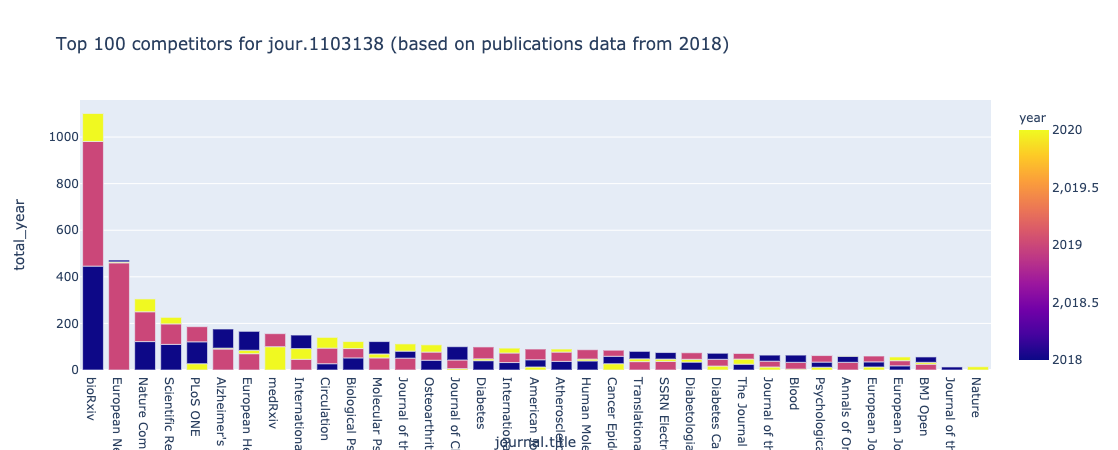

In [9]:

threshold = 100
temp = journals.sort_values("total", ascending=False)[:threshold]

px.bar(journals[:threshold], 
       x="journal.title", y="total_year", 
       color="year",
       hover_name="journal.title", 
       hover_data=['journal.id', 'journal.title', 'total' ], 
       title=f"Top {threshold} competitors for {journal_id} (based on publications data from {start_year})")

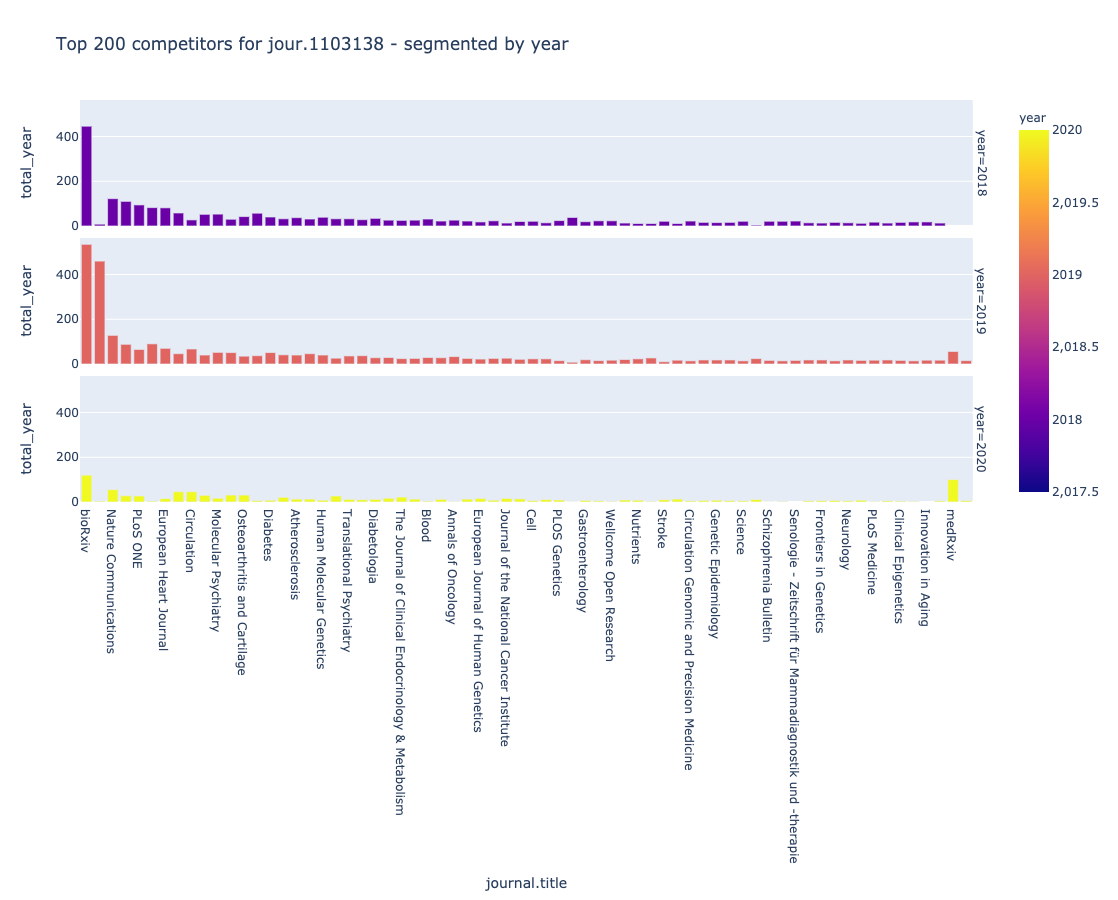

In [10]:
threshold = 200
temp = journals.sort_values("year", ascending=True).groupby("year").head(threshold)

px.bar(journals[:threshold], 
       x="journal.title", y="total_year", 
       color="year",
       facet_row="year",
       height=900,
       hover_name="journal.title", 
       hover_data=['journal.id', 'journal.title', 'total' ], 
       title=f"Top {threshold} competitors for {journal_id} - segmented by year")

NOTE the European Neuropsychopharmacology journal has a massive jump in 2019 cause they [published a lot of conference proceedings](https://www.sciencedirect.com/journal/european-neuropsychopharmacology/issues)! See also the journal [Dimensions page](https://app.dimensions.ai/analytics/publication/overview/timeline?and_facet_source_title=jour.1101548) for comparison.. 
